In [1]:
"""
Letting the model learn the starting point of sinusoidal positional encoding
 - Simple masked self attention
 - The model learns where to start within sidusoidal range (using sigmoid from input sequence)
 - With [1:] input and [:-1] target, it is difficult to find the starting point since the prediction point is different every time
"""

'\nLetting the model learn the starting point of sinusoidal positional encoding\n - Simple masked self attention\n'

In [2]:
is_skip = True
# Data params
seq_len = 30
batch_size = 16

# Model params
d_model = 128
nhead = 4
d_ff = 256
dropout = 0.1
num_layers = 4

# Import

In [3]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

import torch
from pytorch_model_summary import summary

# Data

In [4]:
if not is_skip:
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_raw = pd.merge(df_trans, df_meta, on="article_id")

In [5]:
def preprocess(data):
    data = data.copy()

    # Make sales
    data = data.groupby(["t_dat", "article_id"], as_index=False).agg(sales=("customer_id", "count"))

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["article_id"] = data["article_id"].fillna(method="ffill")
    
    # Data to list
    data = data.groupby("article_id", as_index=False)["sales"].agg(list)
    return data

if not is_skip:
    df_prep = df_raw[df_raw["index_name"]=="Ladieswear"].reset_index(drop=True)
    df_prep = preprocess(df_trans)
    df_prep.to_parquet("df_prep.pq")

In [6]:
df_prep = pd.read_parquet("df_prep.pq")
df_prep["size"] = df_prep["sales"].str.len()
df_prep = df_prep[df_prep["size"] >= seq_len+1]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.sales_li = []
        for _, row in tqdm(data.iterrows()):
            sales = self.unfold_data(row["sales"], seq_len+1)
            self.sales_li.append(sales)

        self.sales_li = torch.concat(self.sales_li)
        print(self.sales_li.shape)
    
    def unfold_data(self, data, length):
        data = data.copy()
        data = torch.FloatTensor(data)
        data = data.unfold(0, length, 1)
        return data
       
    def __len__(self):
        return self.sales_li.shape[0]
    
    def __getitem__(self, idx):
        sales = self.sales_li[idx]
        
        decoder_input = sales[:-1].unsqueeze(-1)
        y = sales[1:].unsqueeze(-1)

        # Scale
        decoder_input = torch.log1p(decoder_input)
        y = torch.log1p(y)

        return {"decoder_input": decoder_input,
                "y": y
                }

dataset = Dataset(df_prep, seq_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for data in dataloader:
    print("decoder_input:", data["decoder_input"].shape)
    print("y:", data["y"].shape)
    break

92069it [00:02, 40049.15it/s]


torch.Size([22411751, 31])
decoder_input: torch.Size([16, 30, 1])
y: torch.Size([16, 30, 1])


# Architecture

In [42]:
bs = 16
arr = torch.FloatTensor([[1,2,3],[4,5,6]])
print(arr)

arr[:]

tensor([[1., 2., 3.],
        [4., 5., 6.]])


tensor(2.)

In [55]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, nhead, num_layers, seq_len):
        super().__init__()
        self.pos_enc = self.get_posenc(d_model)
        self.posenc_linear = torch.nn.Linear(seq_len, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.decoderinput_linear = torch.nn.Linear(1, d_model)
        self.decoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, batch_first=True), num_layers)
        self.decoderoutput_linear = torch.nn.Linear(d_model, 1)

    def get_posenc(self, d_model, max_len=300):
        position = torch.arange(max_len).reshape(-1,1)
        i = torch.arange(d_model)//2
        exp_term = 2*i/d_model
        div_term = torch.pow(10000, exp_term).reshape(1, -1)
        pos_encoded = position / div_term

        pos_encoded[:, 0::2] = torch.sin(pos_encoded[:, 0::2])
        pos_encoded[:, 1::2] = torch.cos(pos_encoded[:, 1::2])
        return pos_encoded

    def forward(self, decoder_input):
        starting_point = self.sigmoid(self.posenc_linear(decoder_input.squeeze()))
        starting_point = torch.ceil(starting_point * decoder_input.shape[1]).type(torch.int)
        pos_enc = []
        for point in starting_point:
            pos_enc.append(self.pos_enc[point:point+decoder_input.shape[1]])
        pos_enc = torch.stack(pos_enc)       
        
        decoder_input = self.decoderinput_linear(decoder_input) + pos_enc
        decoder_output = self.decoder(decoder_input)
        output = self.decoderoutput_linear(decoder_output)      
        
        return output, pos_enc

model = Transformer(d_model, nhead, num_layers, seq_len)
summary(model,
        data["decoder_input"],
        show_parent_layers=True, print_summary=True)

--------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)        Output Shape         Param #     Tr. Param #
     Transformer                Linear-1             [16, 1]              31              31
     Transformer               Sigmoid-2             [16, 1]               0               0
     Transformer                Linear-3       [16, 30, 128]             256             256
     Transformer    TransformerEncoder-4       [16, 30, 128]       2,372,096       2,372,096
     Transformer                Linear-5         [16, 30, 1]             129             129
Total params: 2,372,512
Trainable params: 2,372,512
Non-trainable params: 0
--------------------------------------------------------------------------------------------


'--------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)        Output Shape         Param #     Tr. Param #\n============================================================================================\n     Transformer                Linear-1             [16, 1]              31              31\n     Transformer               Sigmoid-2             [16, 1]               0               0\n     Transformer                Linear-3       [16, 30, 128]             256             256\n     Transformer    TransformerEncoder-4       [16, 30, 128]       2,372,096       2,372,096\n     Transformer                Linear-5         [16, 30, 1]             129             129\n============================================================================================\nTotal params: 2,372,512\nTrainable params: 2,372,512\nNon-trainable params: 0\n--------------------------------------------------------------------------

# Train

epoch 0 - loss: 0.22381:   0%|          | 0/1400735 [00:00<?, ?it/s]


TypeError: unhashable type: 'list'

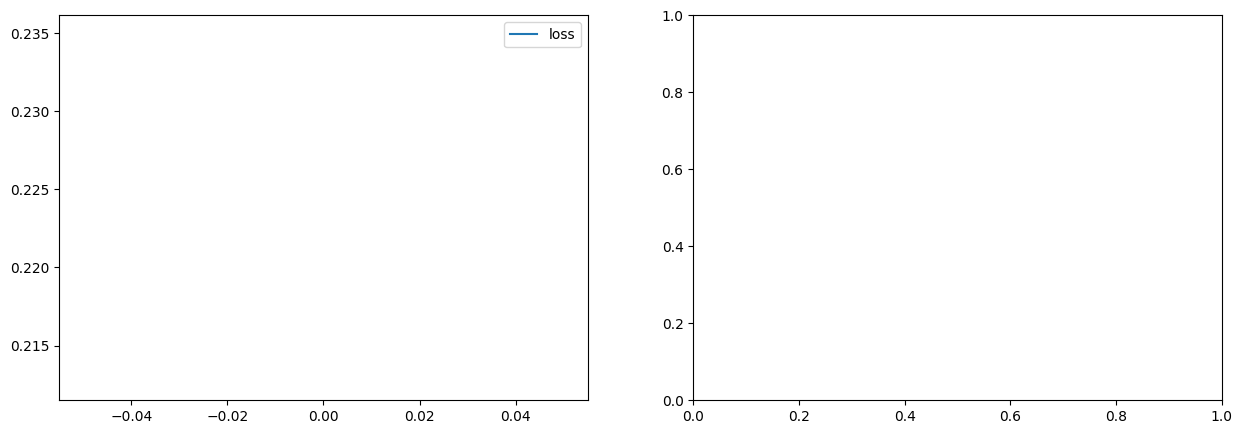

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss()

class Report():
    def __init__(self, window):
        self.window = window
        self.loss_li = []

    def plot_sample(self, loss_li, y, pred, pos_enc):
        plt.figure(figsize=(15,5))
        nrows, ncols = 1,2

        plt.subplot(nrows, ncols, 1)
        plt.plot(loss_li, label="loss")
        plt.legend()

        plt.subplot(nrows, ncols, 2)
        temp = df_prep.copy()
        temp = temp.apply(lambda x:  in x["sales"])
        # temp = temp[temp["sales"].isin([30., 48,])]
        display(temp)
        raise

        plt.show()

    def report(self, loss, y, pred, pos_enc, pbar, e, isplot=False):
        self.loss_li.append(loss.item())
        pbar.set_description(f"epoch {e} - loss: {np.round(np.mean(self.loss_li[-self.window:]), 5)}")
        
        if isplot:
            clear_output(wait=True)
            self.plot_sample(self.loss_li[-self.window:], y, pred, pos_enc)

def train(e):
    model.train()
    pbar = tqdm(dataloader)
    report = Report(window=100)

    for n, data in enumerate(pbar):
        optimizer.zero_grad()
        pred, pos_enc = model(data["decoder_input"])
        loss = mse_loss(data["y"], pred)
        loss.backward()
        optimizer.step()

        report.report(loss, data["y"], pred.detach().numpy(), pos_enc, pbar, e, isplot=True)
        

epoch = 10
for e in range(epoch):
    train(e)
    break